In [2]:
# this code is written by Changyi Yang used for DS Discovery program

import torch.nn as nn
import torch
from torch.utils.data import Dataset, DataLoader
import torch.optim as optim

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

import pandas as pd

In [3]:
torch. __version__

'1.13.1'

In [4]:
# from google.colab import drive
# drive.mount('/content/drive', force_remount=True)
# %cd /content/drive/Shareddrives/PebbleReactorProject/Data

In [19]:
pd.read_csv('binnedpebbles.csv')

,t,0,1,2,3,4,5,6,7,8,...,141,142,143,144,145,146,147,148,149,keff
0,0.000000,3852,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,1.01615
1,8.870571,3922,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,1.01598
2,17.741143,4013,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,1.01509
3,26.611714,3971,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,1.01539
4,35.482286,3704,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,1.01502
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
230,2040.231433,3701,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,1.01389
231,2049.102004,4030,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,1.01352
232,2057.972576,3891,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,1.01335
233,2066.843147,3884,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,1.01320


In [5]:
df = pd.read_csv('fluence.csv')

In [28]:
# define the dataset classes
from sklearn.preprocessing import StandardScaler, MinMaxScaler


class ReactorData(Dataset):
    def __init__(self,file_name, sequence_length, start_percent = 0, end_percent = 1):
        data = pd.read_csv(file_name, skiprows=[0]) # skip the first line
        
        length = data.shape[0]
        data = data[ int(length * start_percent)  : int(length * end_percent)]
        
        # print(data.shape)
        
        
        self.labels = data.iloc[1:, -1:]
        self.data = data.iloc[:-1, 1:-1] # skip the first time column
        
        mm = MinMaxScaler()
        ss = StandardScaler()


        self.data = ss.fit_transform(self.data)
        self.labels = mm.fit_transform(self.labels) 
        
        self.sequence_length = sequence_length
        
    def __len__(self):
        return len(self.labels)//self.sequence_length
    
    def __getitem__(self,idx):
        idx = idx * self.sequence_length
        
        return (torch.tensor(self.data[idx : idx+ self.sequence_length])).double(), \
    (torch.tensor(self.labels[idx : idx+ self.sequence_length])).double()

        

In [29]:
# load the data
training_data = ReactorData('binnedpebbles.csv', sequence_length= 10, start_percent= 0, end_percent= 0.75)
testing_data = ReactorData('binnedpebbles.csv', sequence_length= 10, start_percent= 0.75, end_percent= 1)


In [30]:
training_data[0][0].shape

torch.Size([10, 150])

In [31]:
# define the neural nets
class SimpleLSTM(nn.Module):
    def __init__(self, input_dim, hidden_dim, output_dim, lstm_nums_layer, dropout):
        super().__init__()
        self.input_dim = input_dim
        self.hidden_dim = hidden_dim
        self.output_dim = output_dim
        
        
        self.LSTM = nn.LSTM(input_dim, hidden_dim, lstm_nums_layer, batch_first = True)
        self.dropout = nn.Dropout(dropout)
        
        self.hidden_to_output = nn.Linear(hidden_dim, output_dim)
        
    def forward(self, input):
        # print(input.shape)
        
        hidden_state, _ = self.LSTM(input)
        
        # print(hidden_state.shape)
        output = self.dropout(hidden_state)
        output = self.hidden_to_output(output)
        
        
        return output
    
    


In [32]:
# train the model

input_dim = training_data[0][0].shape[1] # this one takes in the 150 columns
output_dim = training_data[0][1].shape[1] # this one outputs 1 which is the keff


# print(output_dim)

# some adjustable hyper-parameters
hidden_dim = 64
num_hidden_layers = 1
batch_size = 5
learning_rate = 1e-3
weight_decay = 1e-5
epoch_num = 200
dropout = 0.2

model = SimpleLSTM(input_dim, hidden_dim, output_dim, num_hidden_layers, dropout)
model = model.double()

train_dataloader = DataLoader(training_data, batch_size = batch_size)


# the chosn loss function and optimizer
loss_fn = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr = learning_rate, weight_decay= weight_decay)



for epoch in range(epoch_num):
    
    for batch, (X, y) in enumerate(train_dataloader):
        

        
        model.zero_grad()
        
        pred = model(X)
        
        # print(X.shape)
        # print(y.shape)
        
        loss = loss_fn(pred, y)
        
        # backpropagation
        
        loss.backward()
        optimizer.step()
        
        loss = loss.item()
        
    if epoch % 5 == 0:
        print("The loss is {} in epoch {}".format(loss ,epoch))
            

print(f"The training is ended, the final loss is {loss}.")
print("Bye")

The loss is 0.06889572716772621 in epoch 0
The loss is 0.006802740204026667 in epoch 5
The loss is 0.005451652415327754 in epoch 10
The loss is 0.0032287048775287716 in epoch 15
The loss is 0.0065218277852260005 in epoch 20
The loss is 0.004879799075222226 in epoch 25
The loss is 0.0017148695653752184 in epoch 30
The loss is 0.002728706499449773 in epoch 35
The loss is 0.0019402293448785174 in epoch 40
The loss is 0.0017355171327069735 in epoch 45
The loss is 0.0019037524077743409 in epoch 50
The loss is 0.0022278051362822336 in epoch 55
The loss is 0.0011431751194590912 in epoch 60
The loss is 0.0019841291808838798 in epoch 65
The loss is 0.0020548802439031054 in epoch 70
The loss is 0.0011567503601625634 in epoch 75
The loss is 0.0013338613837416459 in epoch 80
The loss is 0.001977483026237989 in epoch 85
The loss is 0.0011280250787434978 in epoch 90
The loss is 0.001023137073575399 in epoch 95
The loss is 0.001262162739066024 in epoch 100
The loss is 0.001926130461340885 in epoch 10

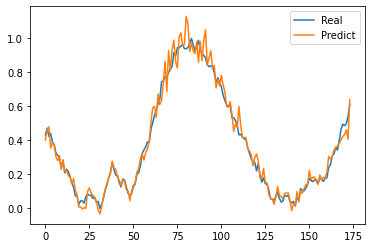

In [33]:
# visualize the training output

import matplotlib.pyplot as plt


X_train = (torch.tensor(training_data.data)).double()
y_train = (torch.tensor(training_data.labels)).double()


plt.figure()
plt.plot(y_train, label = "Real")     
plt.plot(model(X_train).detach().numpy(), label = "Predict")
plt.legend()


0.12860319404851903


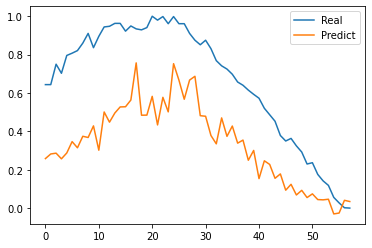

In [26]:
# visualize the test output

import matplotlib.pyplot as plt


X_test = (torch.tensor(testing_data.data)).double()
y_test = (torch.tensor(testing_data.labels)).double()

y_pred = model(X_test)

loss = nn.MSELoss()
print(loss(y_pred, y_test).item())

plt.figure()
plt.plot(y_test, label = "Real")     
plt.plot(y_pred.detach().numpy(), label = "Predict")
plt.legend()

In [27]:
# Define the hyperparameter search space
from ray import tune

config_space = {
    "hidden_size": tune.choice([64, 128, 256]),
    "num_layers": tune.choice([1, 2, 3]),
    "dropout": tune.uniform(0.1, 0.5),
    "lr": tune.loguniform(1e-4, 1e-1),
    "num_epochs": 10
}

# Launch the Ray Tune experiment
analysis = tune.run(
    model,
    config=config_space,
    num_samples=10,
    search_alg=tune.suggest.hyperopt,
    metric="mean_accuracy",
    mode="max"
)

AttributeError: module 'ray.tune' has no attribute 'suggest'

In [ ]:
tuner = tune.Tuner(
    train_mnist,
    param_space = {
    'batch_size': tune.choice([5, 10, 20]),
    'hidden_dim': tune.choice([32, 64, 128]),
    'num_hidden_layers': tune.choice([1, 2, 3, 4, 5]),
    'learning_rate': tune.choice([1e-6, 1e-5, 1e-4, 1e-3]),
    'weight_decay': tune.choice([1e-6, 1e-5, 1e-4, 1e-3]),
    'epoch_num': tune.choice([50, 100, 120, 150, 180, 200, 400]) },
    tune_config=tune.TuneConfig(
            metric="loss",
            mode="min")
)
analysis = tuner.fit()
print("Best config: ", analysis.get_best_result("mean_loss","min"))